In [1]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid"); sns.set_palette("tab10")
import pandas as pd
import numpy as np
from torch.autograd import Variable
from models.vae import VAE
from sklearn.cluster import DBSCAN

In [2]:
train = torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test =  torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [3]:
# def kl_loss(mu, log_var):
#     kl = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     return kl

# def rec_loss(x, x_hat):
#     #mse = (x - x_hat).pow(2).pow(0.5).sum(dim=1).mean(dim=0)
#     mse = nn.MSELoss(reduction="sum")
#     mse = mse(x_hat, x)
#     return mse

In [4]:
#vae = VAE(784, 2)
#opt = optim.Adam(vae.parameters(), lr=1e-3)

In [11]:
class Trainer:
    def __init__(self, model, train_data, test_data):
        self.model = model
        self.train_loader = DataLoader(train_data, batch_size=32)
        self.test_loader = DataLoader(test_data, batch_size=32)
    
        self.opt = optim.Adam(model.parameters(), lr=5e-4)
    
    def _train(self, beta):
        train_loss = 0
        for i, x in enumerate(self.train_loader):
            self.opt.zero_grad()
            loss = self.model.forward(*x, beta=beta)
            loss.backward()
            self.opt.step()
            train_loss += loss.item()
        return train_loss
    
    def _test(self, beta):
        test_loss = 0
        with torch.no_grad():
            for i, x in enumerate(self.train_loader):
                loss = self.model.forward(*x, beta=beta)
                test_loss += loss.item()
        return test_loss
    
    def fit(self, epochs, beta=1.0):
        losses = pd.DataFrame(index=list(range(epochs)), columns = ["Train", "Test"])
        for e in range(epochs):
            train_loss = self._train(beta)
            test_loss = self._test(beta)
            losses.loc[e, ["Train", "Test"]] = train_loss, test_loss
            print(f"Epoch: {e}, Train: {np.round(train_loss, 2)}, Test: {np.round(test_loss, 2)}")
        return losses

In [12]:
vae = VAE(784, 2)
t = Trainer(vae, train, test)

In [33]:
losses = t.fit(10)

Epoch: 0, Train: 1.8205702550567875e+19, Test: 56205096946.99
Epoch: 1, Train: 209907903.93, Test: 29496311.82
Epoch: 2, Train: 25864174.53, Test: 26790666.72
Epoch: 3, Train: 25372703.54, Test: 27393289.0
Epoch: 4, Train: 26588022.48, Test: 26693046.16
Epoch: 5, Train: 25079018.81, Test: 25835547.55
Epoch: 6, Train: 24954706.49, Test: 25366568.01
Epoch: 7, Train: 23818897.5, Test: 25060484.65
Epoch: 8, Train: 23445226.64, Test: 24704957.69
Epoch: 9, Train: 23167400.69, Test: 24103921.73


<AxesSubplot:>

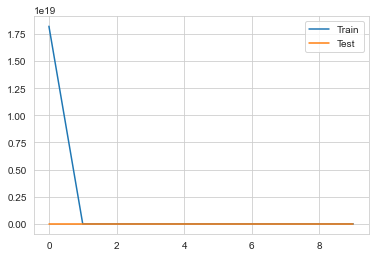

In [34]:
losses.plot()

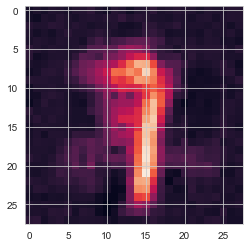

In [35]:
z = torch.randn(1, 2)
plt.imshow(vae.decode(z).reshape(28,28).detach().numpy())


In [36]:
X = []
Y = []
for i, (x,y) in enumerate(t.train_loader):
    X.append(x.flatten(1))
    Y.append(y)
    if i > 10:
        break
X = torch.cat(X)#.detach().numpy()
Y = torch.cat(Y)#.detach().numpy()

In [37]:
Z = vae.encode(X).detach().numpy()
y = Y.detach().numpy()

<AxesSubplot:>

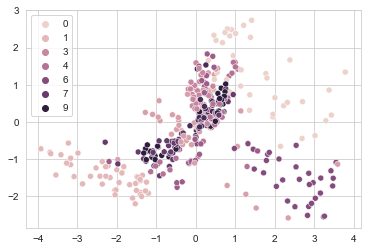

In [38]:
sns.scatterplot(x=Z[:,0], y = Z[:,1], hue=y)

In [39]:
N = 3000
zz = []
xx = []
alpha = 0.005
eps = 0.1
X_ = X.clone()
with torch.no_grad():
    for i in range(N):
        x_smooth = X_ + torch.randn_like(X_) * np.sqrt(eps)
        z, mu, log_var = vae.enc(x_smooth)
        zz.append(mu.unsqueeze(0))
        x_hat = vae.dec(z)
        grad = x_smooth - x_hat
        X_ -= grad * alpha
        xx.append(X_.unsqueeze(0))

<AxesSubplot:>

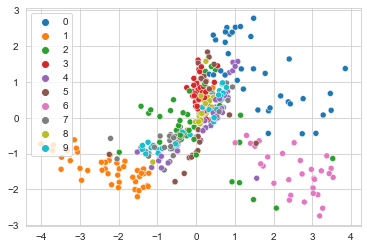

In [40]:
z_np = torch.cat(zz).detach().numpy()
sns.scatterplot(x=z_np[0, :,0], y = z_np[0, :,1], hue=y, palette="tab10")

<AxesSubplot:>

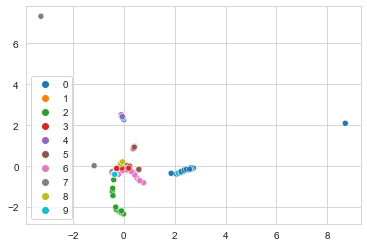

In [29]:
sns.scatterplot(x=z_np[-1, :,0], y = z_np[-1, :,1], hue=y, palette="tab10")

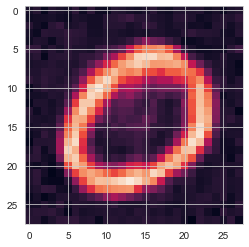

In [30]:
wow = vae.decode(torch.Tensor([[2.7, 1]]))
plt.imshow(wow.detach().numpy().reshape(28,28))

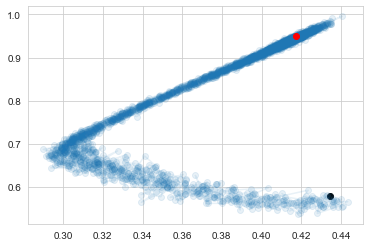

In [31]:
i = 12
plt.plot(z_np[0, i, 0], z_np[0, i, 1], marker="o", color="black")
plt.plot(z_np[:, i,0], z_np[:, i, 1], marker="o", alpha=0.1)
plt.plot(z_np[-1, i, 0], z_np[-1, i, 1], marker="o", color="red")

In [32]:
X_.shape

torch.Size([384, 784])

In [86]:
cluster = DBSCAN()
x_np = torch.cat(xx).detach().numpy()
x_np.shape

(3000, 384, 784)

In [96]:
z_df1 = pd.DataFrame(z_np[-1]).dropna()
wow = cluster.fit(z_df1)

In [97]:
wow.labels_

array([ 0,  0,  1,  1,  1,  2,  3,  0, -1,  1,  0,  1,  0,  4,  1,  5,  2,
        6,  1, -1,  0,  1,  1,  0,  5,  1,  0,  0,  1, -1,  2,  6,  1,  0,
        1,  6,  0,  1,  4,  3,  2,  3,  1,  0,  1,  2,  1,  0,  0,  0,  7,
        1,  1,  1,  2,  7,  1,  1,  1, -1,  1,  0,  0,  1,  1,  0,  1,  7,
        0,  0,  1,  8,  0,  0,  0,  5,  1,  1,  1,  0,  0,  5,  4,  1,  2,
        0,  1,  7,  1,  4,  1,  1,  0,  2,  0,  1,  2,  0,  1,  1,  1,  1,
        1,  4,  0,  7, -1,  1,  0,  3,  1,  7,  1,  1,  5,  0,  0,  2,  7,
        5,  1,  8,  2,  6,  1,  3,  0,  0,  1,  3,  1,  0,  0,  0,  1,  0,
        1,  1,  1,  1, -1,  0,  1,  2,  6,  1,  0,  6,  0,  1,  1,  1,  0,
        7,  0, -1,  5,  0,  5,  1,  1, -1,  0,  1,  1,  1,  0,  1,  5,  1,
        1,  3,  1,  1,  1,  1,  0,  1,  2,  0,  1,  3,  1, -1,  5,  2, -1,
        5,  1,  0,  1,  1,  1,  1,  2,  0, -1,  3,  1,  0,  0,  6,  1,  7,
        2,  1,  7,  0,  1,  3,  5,  1,  0,  0,  1, -1,  0,  5,  4, -1,  1,
        2,  0,  1,  1,  0

<AxesSubplot:xlabel='0', ylabel='1'>

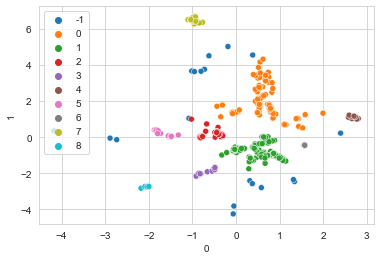

In [99]:
sns.scatterplot(x=z_df1.iloc[:,0], y = z_df1.iloc[:,1], hue=wow.labels_, palette="tab10")

In [73]:
pd.DataFrame(x_np[-1]).dropna()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.432171,-0.389818,-0.445099,-0.392695,-0.454393,-0.416184,-0.434436,-0.397033,-0.436551,-0.419351,...,-0.386804,-0.401949,-0.463521,-0.434110,-0.405292,-0.441261,-0.430939,-0.413965,-0.449005,-0.414986
1,-0.473455,-0.264187,-0.449403,-0.414558,-0.501390,-0.392436,-0.423356,-0.336778,-0.426511,-0.295579,...,-0.406880,-0.428358,-0.416249,-0.395688,-0.490606,-0.427233,-0.447703,-0.459712,-0.455936,-0.358582
2,-0.408262,-0.466716,-0.421298,-0.447975,-0.443969,-0.447503,-0.418491,-0.397247,-0.387462,-0.510221,...,-0.435072,-0.411654,-0.435775,-0.414535,-0.412148,-0.406189,-0.403920,-0.382408,-0.410956,-0.399424
3,-0.417616,-0.514432,-0.406144,-0.500492,-0.537511,-0.383440,-0.412013,-0.429975,-0.454342,-0.509117,...,-0.431372,-0.450007,-0.387510,-0.449971,-0.467292,-0.446801,-0.398635,-0.461447,-0.483255,-0.467695
4,-0.453478,-0.475223,-0.433132,-0.420628,-0.397940,-0.417438,-0.403900,-0.477146,-0.434149,-0.536027,...,-0.445790,-0.435258,-0.472490,-0.409858,-0.437230,-0.411612,-0.393685,-0.381423,-0.408167,-0.434852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-0.421930,-0.494231,-0.408821,-0.433938,-0.498432,-0.417963,-0.422065,-0.437948,-0.465457,-0.495280,...,-0.463826,-0.428153,-0.421244,-0.442348,-0.402139,-0.440192,-0.397224,-0.408020,-0.446599,-0.461621
380,-0.388275,-0.479754,-0.390505,-0.462307,-0.429053,-0.425679,-0.426304,-0.442216,-0.419225,-0.497744,...,-0.422376,-0.416684,-0.453488,-0.432157,-0.427391,-0.443425,-0.420545,-0.376776,-0.409014,-0.429571
381,-0.437659,-0.420300,-0.385619,-0.475012,-0.475448,-0.402169,-0.392165,-0.408832,-0.423957,-0.422042,...,-0.422529,-0.452352,-0.388722,-0.457613,-0.466821,-0.441068,-0.363711,-0.465028,-0.460180,-0.447684
382,-0.437835,-0.515397,-0.395338,-0.527279,-0.503578,-0.446199,-0.415604,-0.440284,-0.399200,-0.537197,...,-0.496420,-0.493368,-0.410096,-0.431928,-0.411751,-0.449927,-0.429151,-0.490322,-0.465652,-0.460956


In [16]:
X_ = X.clone()
X_ = Variable(X_, requires_grad=True)
#vae.requires_grad_(False)
N = 1500
opts = optim.Adam([X_], lr=alpha)
mse = nn.MSELoss()
zz2 = []
xx2 = []
for i in range(N):
    opts.zero_grad()
    x_smooth = X_ + torch.randn_like(X_)*np.sqrt(0.3)
    z, mu, log_var = vae.enc(x_smooth)
    zz2.append(mu.unsqueeze(0))
    x_hat = vae.dec(z)
    loss = mse(x_hat, x_smooth)
    loss.backward()
    opts.step()